In [1]:
%load_ext autoreload
%autoreload true

In [2]:
import sys
sys.path.insert(0, '../..')

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

from utils import DataManager
from Storage import *

# Instantiation of the best model

In [3]:
from sklearn.decomposition import PCA

scaler = PCA(n_components=12, whiten=True)

In [4]:
from xgboost import XGBClassifier

# Best model from hyper optimisation
model = XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.8285226685878813, colsample_bynode=1,
              colsample_bytree=0.8891871309165946, enable_categorical=False,
              gamma=0.9536157703771063, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3013088280616817,
              max_delta_step=0, max_depth=6, min_child_weight=13, 
              monotone_constraints='()', n_estimators=1800, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=4,
              reg_alpha=0.28909188019520954, reg_lambda=1.7771454587775033,
              scale_pos_weight=1, seed=4, subsample=0.6391338668065498,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

c:\Users\mv242848\Anaconda3\envs\ai_dhc_v2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Loading train data and training model

In [5]:
from load_fault_dataset import SubstationFaultLoader

loader = StorageFaultLoader(os.path.join(DATA_ROOT, 'StorageSimplified-20220906'))

train_faults = pd.read_csv(TRAIN_SPEC, index_col=0)
data_train, metadata_train = loader.load_fault_dataset_df(list(train_faults.index.values))
dm_train = DataManager()
dm_train.prepare_database(data_train, metadata_train, del_cols=HIDDEN_VARS+['anomaly'])

X_train, y_train = dm_train.split_X_Y_concat()

In [6]:
scaler.fit(X_train)

PCA(n_components=12, whiten=True)

In [7]:
model.fit(scaler.transform(X_train), y_train)

[18:42:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.8285226685878813, colsample_bynode=1,
              colsample_bytree=0.8891871309165946, enable_categorical=False,
              gamma=0.9536157703771063, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3013088280616817,
              max_delta_step=0, max_depth=6, min_child_weight=13, missing=nan,
              monotone_constraints='()', n_estimators=1800, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=4,
              reg_alpha=0.28909188019520954, reg_lambda=1.7771454587775033,
              scale_pos_weight=1, seed=4, subsample=0.6391338668065498,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Load test data and computing predictions

In [8]:
test_faults = pd.read_csv(TEST_SPEC, index_col=0)
data_test , metadata_test = loader.load_fault_dataset_df(list(test_faults.index.values))
dm_test = DataManager()
dm_test.prepare_database(data_test, metadata_test, del_cols=HIDDEN_VARS+['anomaly'])

X_test, y_test = dm_test.split_X_Y_concat()

y_pred = model.predict(scaler.transform(X_test))

# Computing model scores

In [9]:
mcc = matthews_corrcoef(y_test,	y_pred)
print("MCC: %.3f" % mcc)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: %.3f" % acc)

MCC: 0.313
Accuracy: 0.607


# Plotting sample results

In [10]:
X_test_plot, y_test_plot = dm_test.split_X_Y()

for p in y_test_plot:
    p.index = pd.TimedeltaIndex(300 * p.index, unit='s')


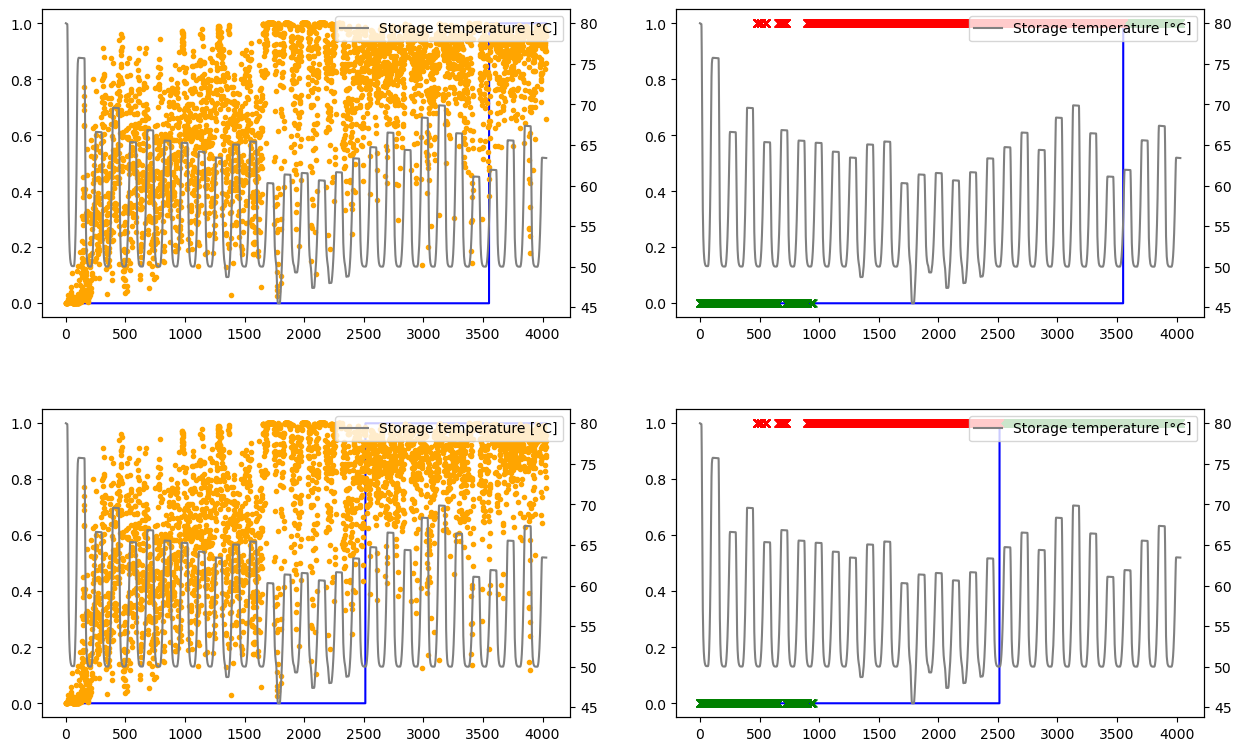

In [18]:
from Yacine.model_evaluation_plots import *

fault_var = 'TempStorage10_K'
fault_var_label = 'Storage temperature [°C]'

test_ids = [7, 8,2] # range(10)
# titles =  [None] * len(test_ids)
titles = [
     'Case with strong degradation of insulation (91%)',
     'Case with medium degradation of insulation (18%)',
     'Case with small degradation of insulation (10%)',
 ]

nb_test = len(test_ids)
#fig, ax = plt.subplots(nb_test, 2, figsize=(25,6*nb_test))
fig = plt.figure(figsize=(15,4*nb_test))

subfigs = fig.subfigures(nrows=nb_test, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(titles[row], fontsize='x-large')
    ax = subfig.subplots(nrows=1, ncols=2)

    ii = test_ids[row]
    y_data = y_test_plot[ii].values.astype(np.float64)
    y_prob = model.predict_proba(scaler.transform(X_test_plot[ii]))[:,1]
    y_pred = alert_trigger(horizon=144, proba=y_prob, threshold=0.5)
    # y_pred = model.predict(scaler.transform(X_test_plot[ii]))
    fault_var_data = X_test_plot[ii][fault_var] - 273.15 # .astype(np.float64)

    plot_proba(ax[0], y_data, y_prob, fault_var_label, fault_var_data)
    plot_true_false(ax[1], y_data, y_pred, fault_var_label, fault_var_data) 